# Computations and Masks with Xarray

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
xr.__version__

'2023.1.0'

Let's open the monthly sea surface temperature (SST) data from the Community Earth System Model v2 (CESM2), which is a Global Climate Model:

In [9]:
ds = xr.open_dataset('https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1M-m')
#ds


Cookie file cannot be read and written: /home/aliraloarca/.cookies


OSError: [Errno -37] NetCDF: Write to read only: b'https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1M-m'

## Arithmetic Operations

Arithmetic operations with a single DataArray automatically apply over all array values (like NumPy). This process is called vectorization.  Let's convert the air temperature from degrees Celsius to kelvins:

In [ ]:
ds.tos + 273.15

Lets's square all values in `tos`:

In [ ]:
ds.tos**2

## Aggregation Methods 

A very common step during data analysis is to summarize the data in question by computing aggregations like `sum()`, `mean()`, `median()`, `min()`, `max()` in which reduced data provide insight into the nature of large dataset. Let's explore some of these aggregation methods.


Compute the mean:

In [ ]:
ds.tos.mean()

Because we specified no `dim` argument the function was applied over all dimensions, computing the mean of every element of `tos` across time and space. It is possible to specify a dimension along which to compute an aggregation. For example, to calculate the mean in time for all locations, specify the time dimension as the dimension along which the mean should be calculated:

In [ ]:
ds.tos.mean(dim='time').plot(size=7);

Compute the temporal min:

In [ ]:
ds.tos.min(dim=['time'])

Compute the spatial sum:

In [ ]:
ds.tos.sum(dim=['lat', 'lon'])

Compute the temporal median:

In [ ]:
ds.tos.median(dim='time')

The following table summarizes some other built-in xarray aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``prod()``               | Compute product of elements            |
| ``sum()``                | Compute sum of elements                |
| ``argmin()``, ``argmax()``| Find index of minimum and maximum value |

## GroupBy: Split, Apply, Combine

Simple aggregations can give useful summary of our dataset, but often we would prefer to aggregate conditionally on some coordinate labels or groups. Xarray provides the so-called `groupby` operation which enables the **split-apply-combine** workflow on xarray DataArrays and Datasets. The split-apply-combine operation is illustrated in this figure

<img src="./images/xarray-split-apply-combine.jpeg">

This makes clear what the `groupby` accomplishes:

- The split step involves breaking up and grouping an xarray Dataset or DataArray depending on the value of the specified group key.
- The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The combine step merges the results of these operations into an output xarray Dataset or DataArray.

We are going to use `groupby` to remove the seasonal cycle ("climatology") from our dataset. See the [xarray `groupby` user guide](https://xarray.pydata.org/en/stable/user-guide/groupby.html) for more examples of what `groupby` can take as an input.

First, let's select a gridpoint closest to a specified lat-lon, and plot a time series of SST at that point. The annual cycle will be quite evident.

In [ ]:
ds.tos.sel(lon=310, lat=50, method='nearest').plot();

### Split

Let's group data by month, i.e. all Januaries in one group, all Februaries in one group, etc.


In [ ]:
ds.tos.groupby(ds.time.dt.month)

<div class="admonition alert alert-info">

In the above code, we are using the `.dt` [`DatetimeAccessor`](https://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html) to extract specific components of dates/times in our time coordinate dimension. For example, we can extract the year with `ds.time.dt.year`. See also the equivalent [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).
    
   </div>

Xarray also offers a more concise syntax when the variable you’re grouping on is already present in the dataset. This is identical to `ds.tos.groupby(ds.time.dt.month)`:

In [ ]:
ds.tos.groupby('time.month')

### Apply & Combine 

Now that we have groups defined, it’s time to “apply” a calculation to the group. These calculations can either be:

- aggregation: reduces the size of the group
- transformation: preserves the group’s full size

At then end of the apply step, xarray will automatically combine the aggregated/transformed groups back into a single object. 



#### Compute climatology 


Let's calculate the climatology at every point in the dataset:


In [ ]:
tos_clim = ds.tos.groupby('time.month').mean()
tos_clim

Plot climatology at a specific point:

In [ ]:
tos_clim.sel(lon=310, lat=50, method='nearest').plot();

Plot zonal mean climatology:

In [ ]:
tos_clim.mean(dim='lon').transpose().plot.contourf(levels=12, cmap='turbo');

Calculate and plot the difference between January and December climatologies:

In [ ]:
(tos_clim.sel(month=1) - tos_clim.sel(month=12)).plot(size=6, robust=True);

#### Compute anomaly

Now let's combine the previous steps to compute climatology and use xarray's `groupby` arithmetic to remove this climatology from our original data:

In [ ]:
gb = ds.tos.groupby('time.month')
tos_anom = gb - gb.mean(dim='time')
tos_anom

In [ ]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot();

Let's compute and visualize the mean global anomaly over time. We need to specify both `lat` and `lon` dimensions in the `dim` argument to `mean()`:

In [ ]:
unweighted_mean_global_anom = tos_anom.mean(dim=['lat', 'lon'])
unweighted_mean_global_anom.plot();

<div class="admonition alert alert-warning">
   

An operation which combines grid cells of different size is not scientifically valid unless each cell is weighted by the size of the grid cell. Xarray has a convenient [`.weighted()`](https://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions) method to accomplish this

</div>


Let's first load the cell area data from another CESM2 dataset that contains the weights for the grid cells:

In [ ]:
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello
areacello

As before, let's calculate area-weighted mean global anomaly:

In [ ]:
weighted_mean_global_anom = tos_anom.weighted(areacello).mean(dim=['lat', 'lon'])

Let's plot both unweighted and weighted means:

In [ ]:
unweighted_mean_global_anom.plot(size=7)
weighted_mean_global_anom.plot()
plt.legend(['unweighted', 'weighted']);

## Other high level computation functionality

- `resample`: [Groupby-like functionality specifialized for time dimensions. Can be used for temporal upsampling and downsampling](https://xarray.pydata.org/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
- `rolling`: [Useful for computing aggregations on moving windows of your dataset e.g. computing moving averages](https://xarray.pydata.org/en/stable/user-guide/computation.html#rolling-window-operations)
- `coarsen`: [Generic functionality for downsampling data](https://xarray.pydata.org/en/stable/user-guide/computation.html#coarsen-large-arrays)



In [22]:
from pathlib import Path
ds = xr.open_dataset(Path('data/WW3_mediterr_19980701.nc'))
ds

<xarray.Dataset>
Dimensions:     (time: 744, latitude: 180, longitude: 336)
Coordinates:
  * time        (time) datetime64[ns] 1998-07-01 ... 1998-07-31T23:00:00
    step        (time) timedelta64[ns] ...
    surface     int64 ...
  * latitude    (latitude) float64 46.11 46.02 45.93 45.84 ... 30.18 30.09 30.0
  * longitude   (longitude) float64 -5.9 -5.773 -5.645 ... 36.5 36.63 36.76
    valid_time  (time) datetime64[ns] ...
Data variables:
    swh         (time, latitude, longitude) float32 ...
    mwp         (time, latitude, longitude) float32 ...
    perpw       (time, latitude, longitude) float32 ...
    mwd         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cnmc
    GRIB_centreDescription:  Rome 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Rome 
    history:                 2021-02-12T16:53:30 GRIB to CDM+CF via cfgrib-0....

For example, resample to annual frequency:

In [32]:
import pandas as pd
ds['time_new'] = pd.to_datetime('2023-01-03')+ ds.step
ds.swap_dims({'time':'time_new'})


<xarray.Dataset>
Dimensions:     (time_new: 744, latitude: 180, longitude: 336)
Coordinates:
    time        (time_new) datetime64[ns] 1998-07-01 ... 1998-07-31T23:00:00
    step        (time_new) timedelta64[ns] 00:00:00 ... 30 days 23:00:00
    surface     int64 ...
  * latitude    (latitude) float64 46.11 46.02 45.93 45.84 ... 30.18 30.09 30.0
  * longitude   (longitude) float64 -5.9 -5.773 -5.645 ... 36.5 36.63 36.76
    valid_time  (time_new) datetime64[ns] ...
  * time_new    (time_new) datetime64[ns] 2023-01-03 ... 2023-02-02T23:00:00
Data variables:
    swh         (time_new, latitude, longitude) float32 ...
    mwp         (time_new, latitude, longitude) float32 ...
    perpw       (time_new, latitude, longitude) float32 ...
    mwd         (time_new, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cnmc
    GRIB_centreDescription:  Rome 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Rome 
    history:                 2021-02-12T16:53:30 GRIB to CDM+CF via cfgrib-0....

In [27]:
r = ds.swh.resample({'time':'D'})

In [28]:
r

DataArrayResample, grouped over '__resample_dim__'
31 groups with labels 1998-07-01, ..., 1998-07-31.

In [29]:
r.mean()

<xarray.DataArray 'swh' (time: 31, latitude: 180, longitude: 336)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    surface    int64 ...
  * latitude   (latitude) float64 46.11 46.02 45.93 45.84 ... 30.18 30.09 30.0
  * longitude  (longitude) float64 -5.9 -5.773 -5.645 ... 36.5 36.63 36.76
  * time       (time) datetime64[ns] 1998-07-01 1998-07-02 ... 1998-07-31
Attributes: (12/27)
    GRIB_paramId:                             140229
    GRIB_shortName:                           swh
    GRIB_units:                               m
    GRIB_name:                                Significant height of combined ...
    GRIB_cfVarName:                           swh
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   46.11
    GRIB_latitudeOfLastGridPointInDegrees:    30.0
    long_name:                                Significant height of combined ...
    units:                                    m

Compute a 5-month moving average:

In [34]:
m_avg = ds.swh.rolling(time=5, center=True).mean()
m_avg

<xarray.DataArray 'swh' (time: 744, latitude: 180, longitude: 336)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1998-07-01 ... 1998-07-31T23:00:00
    step        (time) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 23:00:00
    surface     int64 ...
  * latitude    (latitude) float64 46.11 46.02 45.93 45.84 ... 30.18 30.09 30.0
  * longitude   (longitude) float64 -5.9 -5.773 -5.645 ... 36.5 36.63 36.76
    valid_time  (time) datetime64[ns] ...
Attributes: (12/27)
    GRIB_paramId:                             140229
    GRIB_shortName:                           swh
    GRIB_units:                               m
    GRIB_name:                                Significant height of combined ...
    GRIB_cfVarName:                           swh
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   46.11
    GRIB_latitudeOfLastGridPointInDegrees:    30.0
    long_name:                                Significant height of combined ...
    units:                                    m

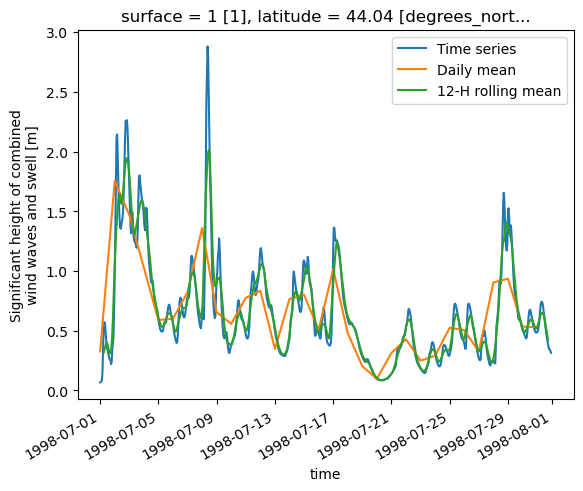

In [58]:
lat = 44
lon = 9

ds_pt = ds.swh.sel(longitude=lon, latitude=lat, method='nearest')

ds_pt.plot()
ds_pt.resample(indexer={'time':'D'}).mean().plot()
ds_pt.rolling(time=12, center=True).mean().plot()
plt.legend(['Time series', 'Daily mean', '12-H rolling mean'])

## Masking Data


Using the `xr.where()` or `.where()` method, elements of an xarray Dataset or xarray DataArray that satisfy a given condition or multiple conditions can be replaced/masked. To demonstrate this, we are going to use the `.where()` method on the `tos` DataArray. 

We will use the same sea surface temperature dataset:

In [59]:
ds

<xarray.Dataset>
Dimensions:     (time: 744, latitude: 180, longitude: 336)
Coordinates:
  * time        (time) datetime64[ns] 1998-07-01 ... 1998-07-31T23:00:00
    step        (time) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 23:00:00
    surface     int64 ...
  * latitude    (latitude) float64 46.11 46.02 45.93 45.84 ... 30.18 30.09 30.0
  * longitude   (longitude) float64 -5.9 -5.773 -5.645 ... 36.5 36.63 36.76
    valid_time  (time) datetime64[ns] ...
Data variables:
    swh         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    mwp         (time, latitude, longitude) float32 ...
    perpw       (time, latitude, longitude) float32 ...
    mwd         (time, latitude, longitude) float32 ...
    time_new    (time) datetime64[ns] 2023-01-03 ... 2023-02-02T23:00:00
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cnmc
    GRIB_centreDescription:  Rome 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Rome 
    history:                 2021-02-12T16:53:30 GRIB to CDM+CF via cfgrib-0....

### Using `where` with one condition

Imagine we wish to analyze just the last time in the dataset. We could of course use `.isel()` for this:

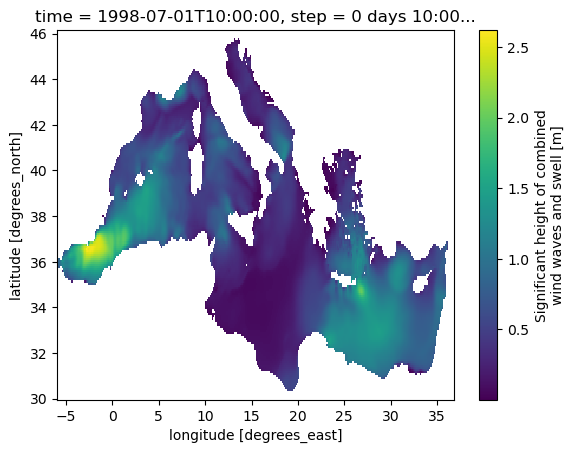

In [65]:
sample = ds.swh.isel(time=10)
sample.plot()

Unlike `.isel()` and `.sel()` that change the shape of the returned results, `.where()` preserves the shape of the original data. It accomplishes this by returning values from the original DataArray or Dataset if the `condition` is `True`, and fills in values (by default `nan`) wherever the `condition` is `False`. 

Before applying it, let's look at the [`.where()` documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html). As the documention points out, the conditional expression in `.where()` can be: 

- a DataArray
- a Dataset
- a function

For demonstration purposes, let's use `.where()` to mask locations with temperature values greater than `0`:

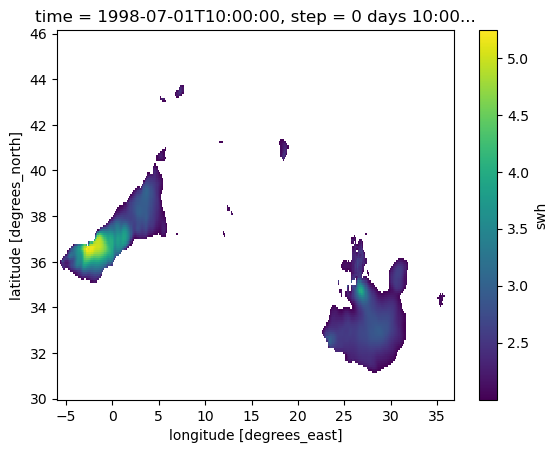

In [69]:
masked_sample = sample.where(sample > 1.0)
(masked_sample + sample).plot()

Let's plot both our original sample, and the masked sample:

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(19, 6))
sample.plot(ax=axes[0])
masked_sample.plot(ax=axes[1]);

### Using `where` with multiple conditions

`.where()` allows providing multiple conditions. To do this, we need to make sure each conditional expression is enclosed in `()`. To combine conditions, we use the `bit-wise and` (`&`) operator and/or the `bit-wise or` (`|`). Let's use `.where()` to mask locations with temperature values less than 25 and greater than 30:

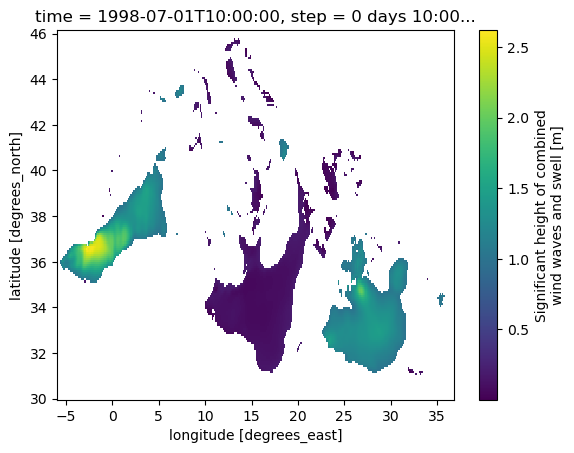

In [72]:
sample.where((sample > 1) | (sample < 0.2)).plot()

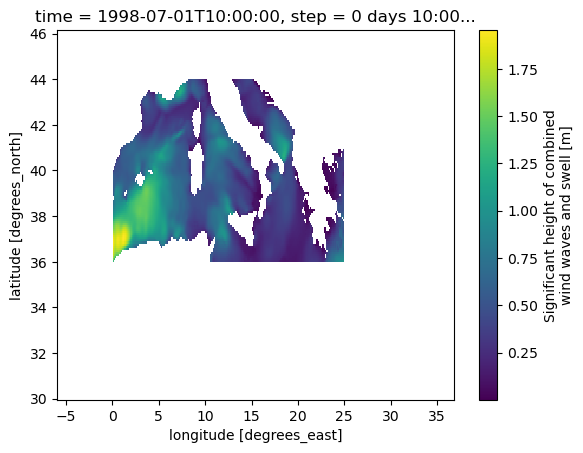

In [91]:
sample.where(
    (sample.latitude < 44) & (sample.latitude > 36) & 
    (sample.longitude > 0) & (sample.longitude < 25)
).plot()

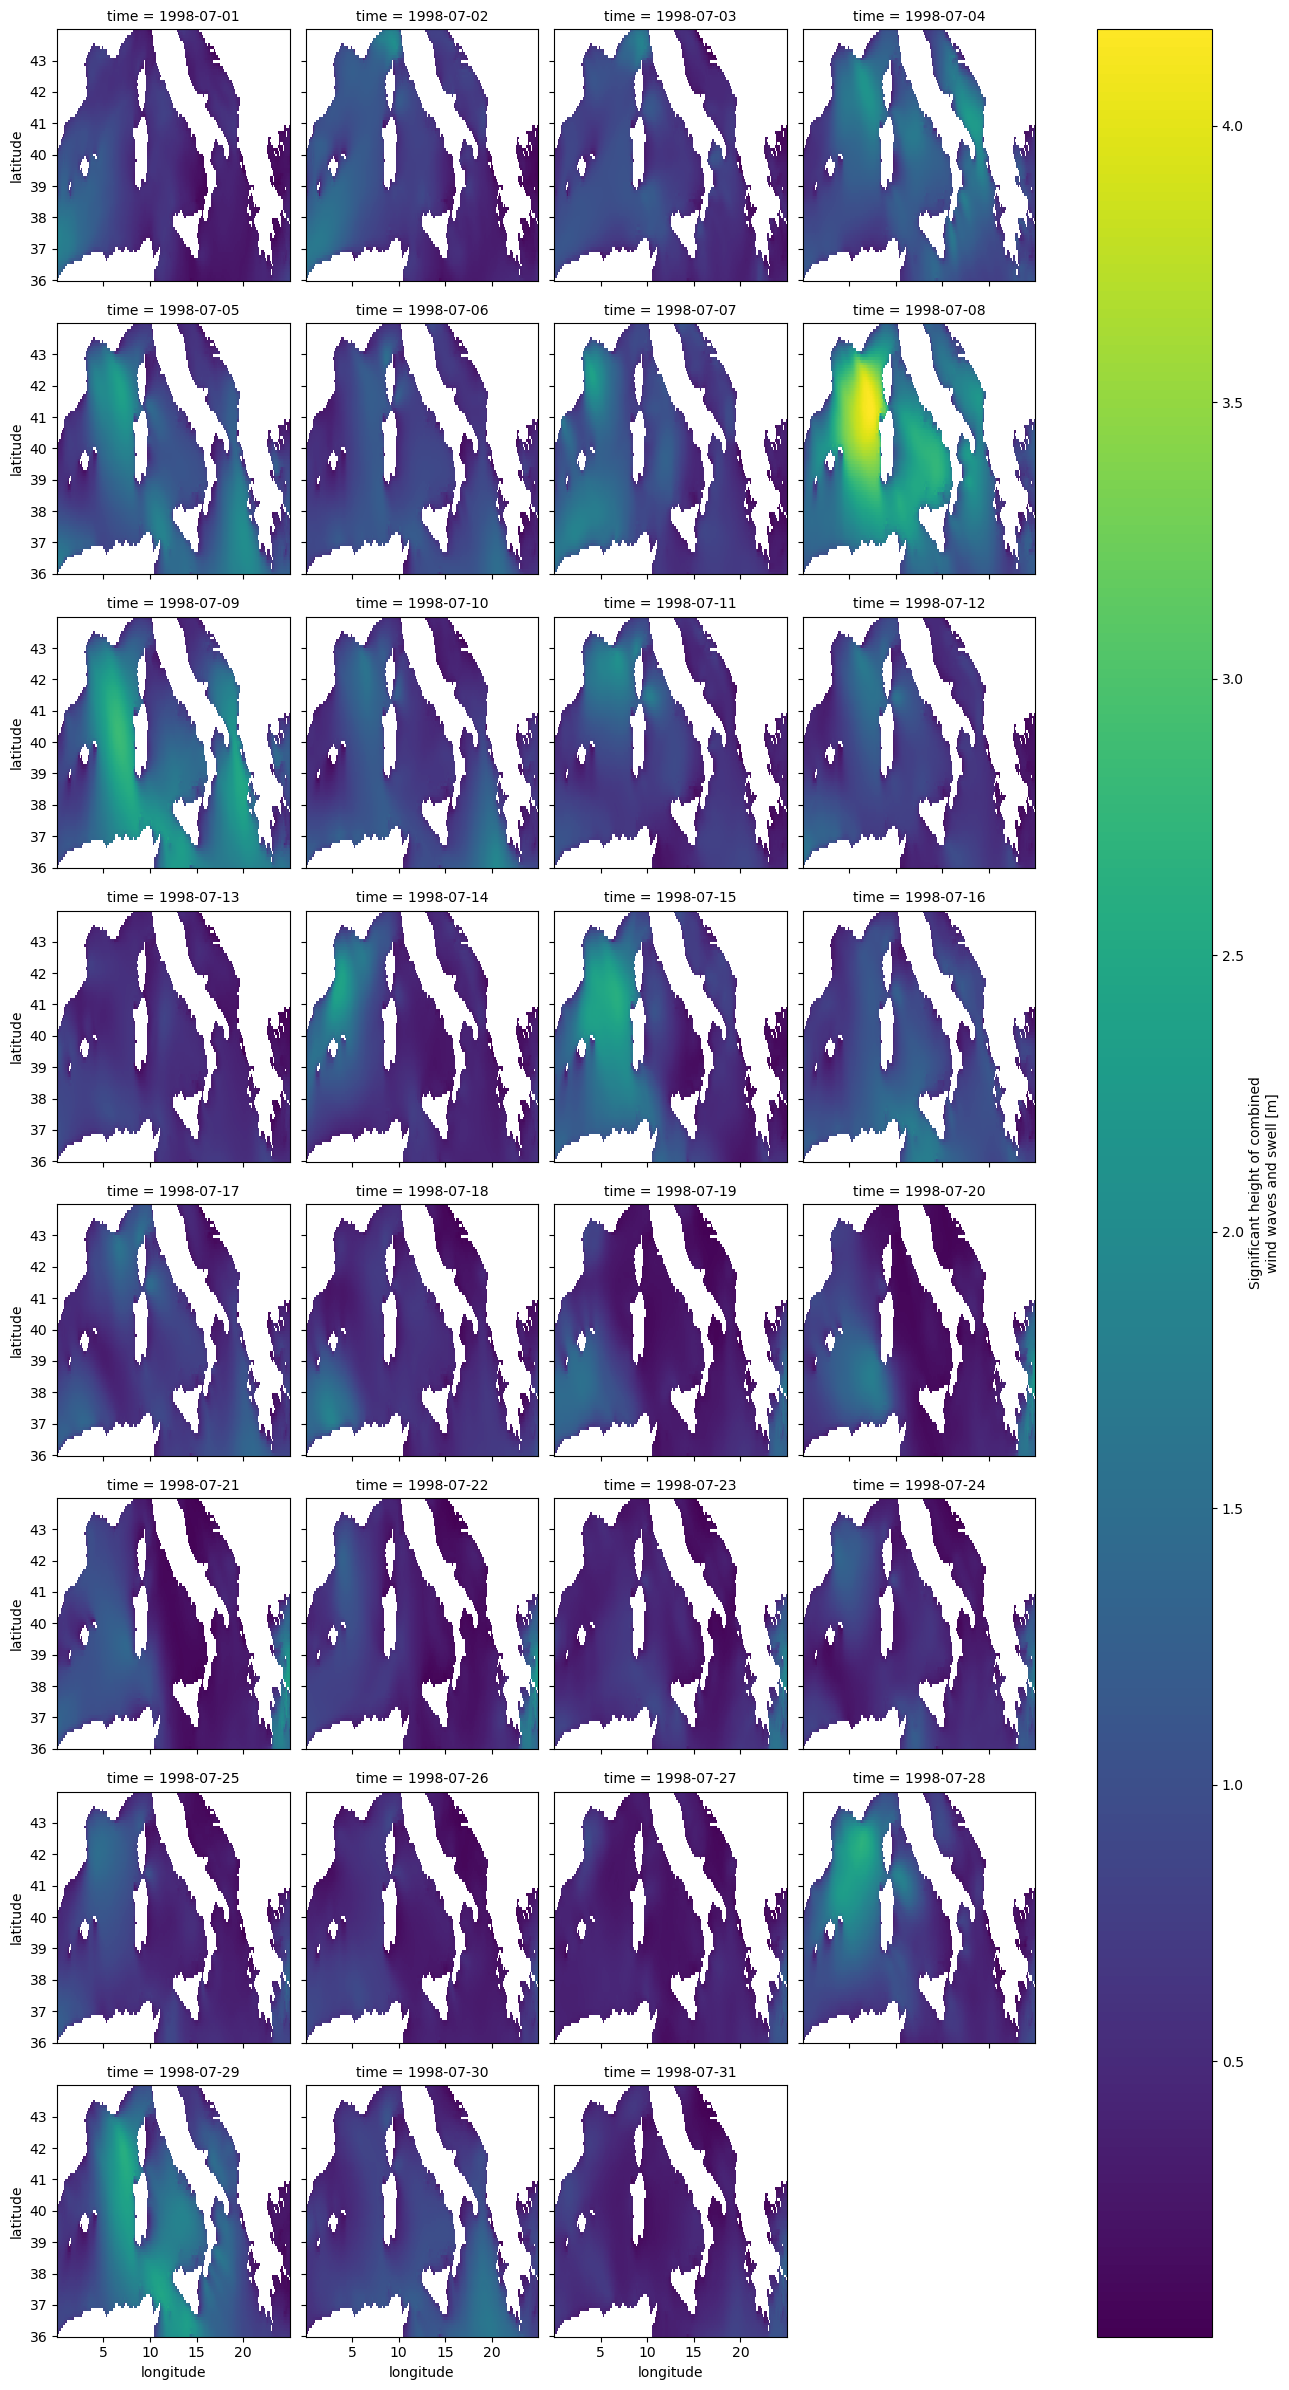

In [100]:
ds.sel(latitude=slice(44, 36), longitude=slice(0, 25)).resample({'time': 'D'}).mean().swh.plot(col='time', col_wrap=4)

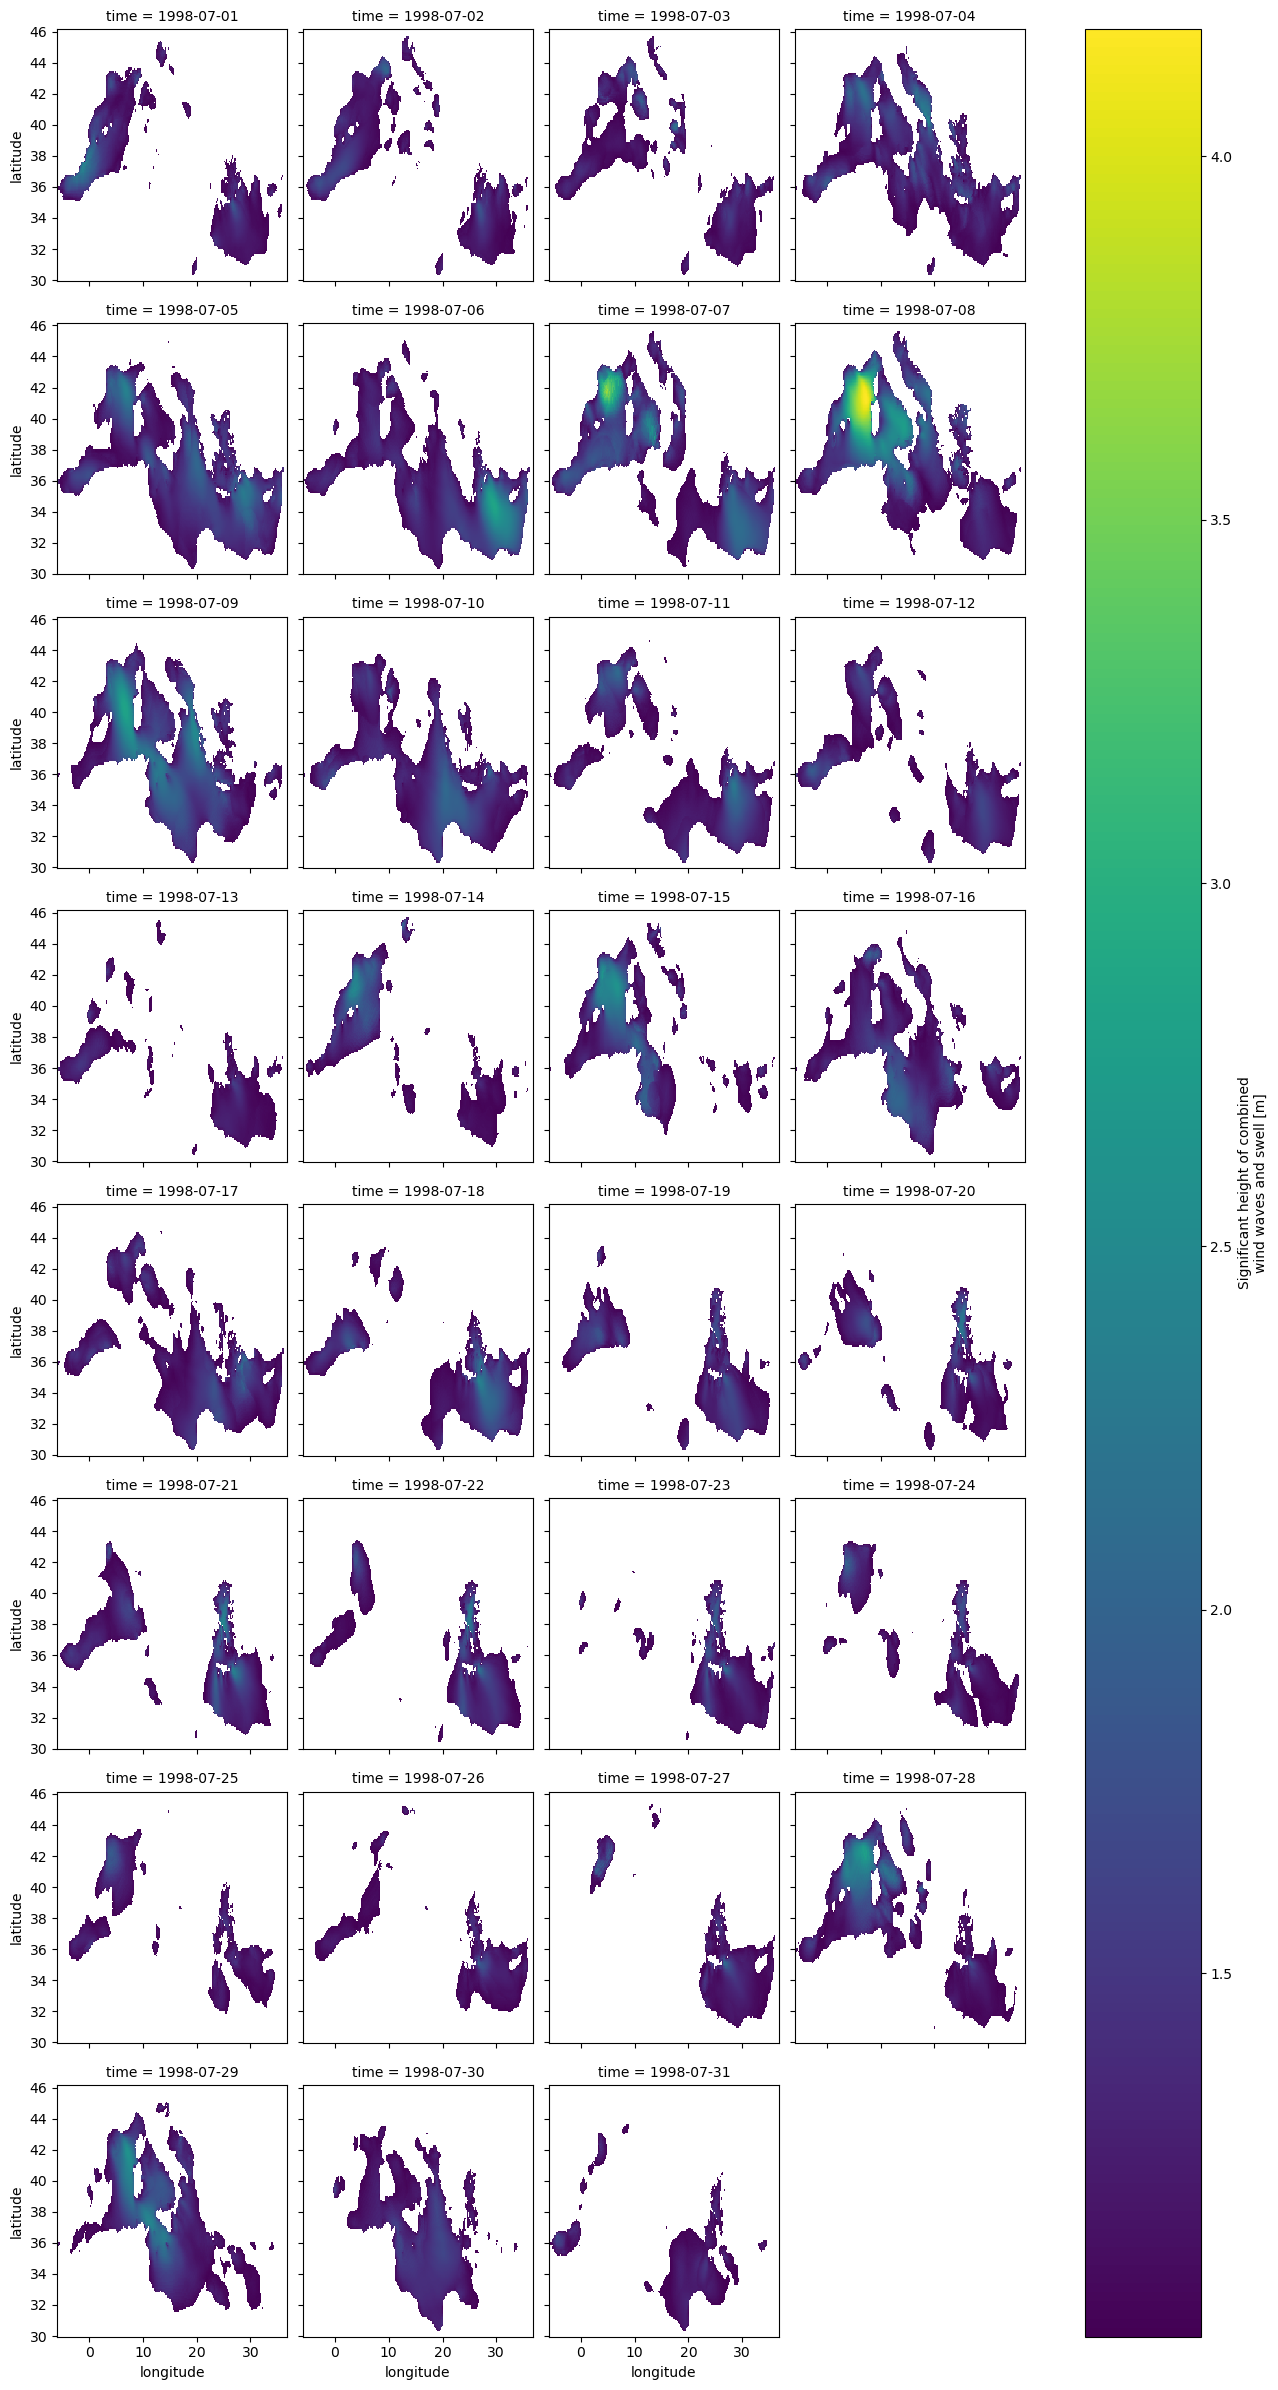

In [101]:
ds.swh.where(ds.swh>1).resample({'time': 'D'}).mean().plot(col='time', col_wrap=4)

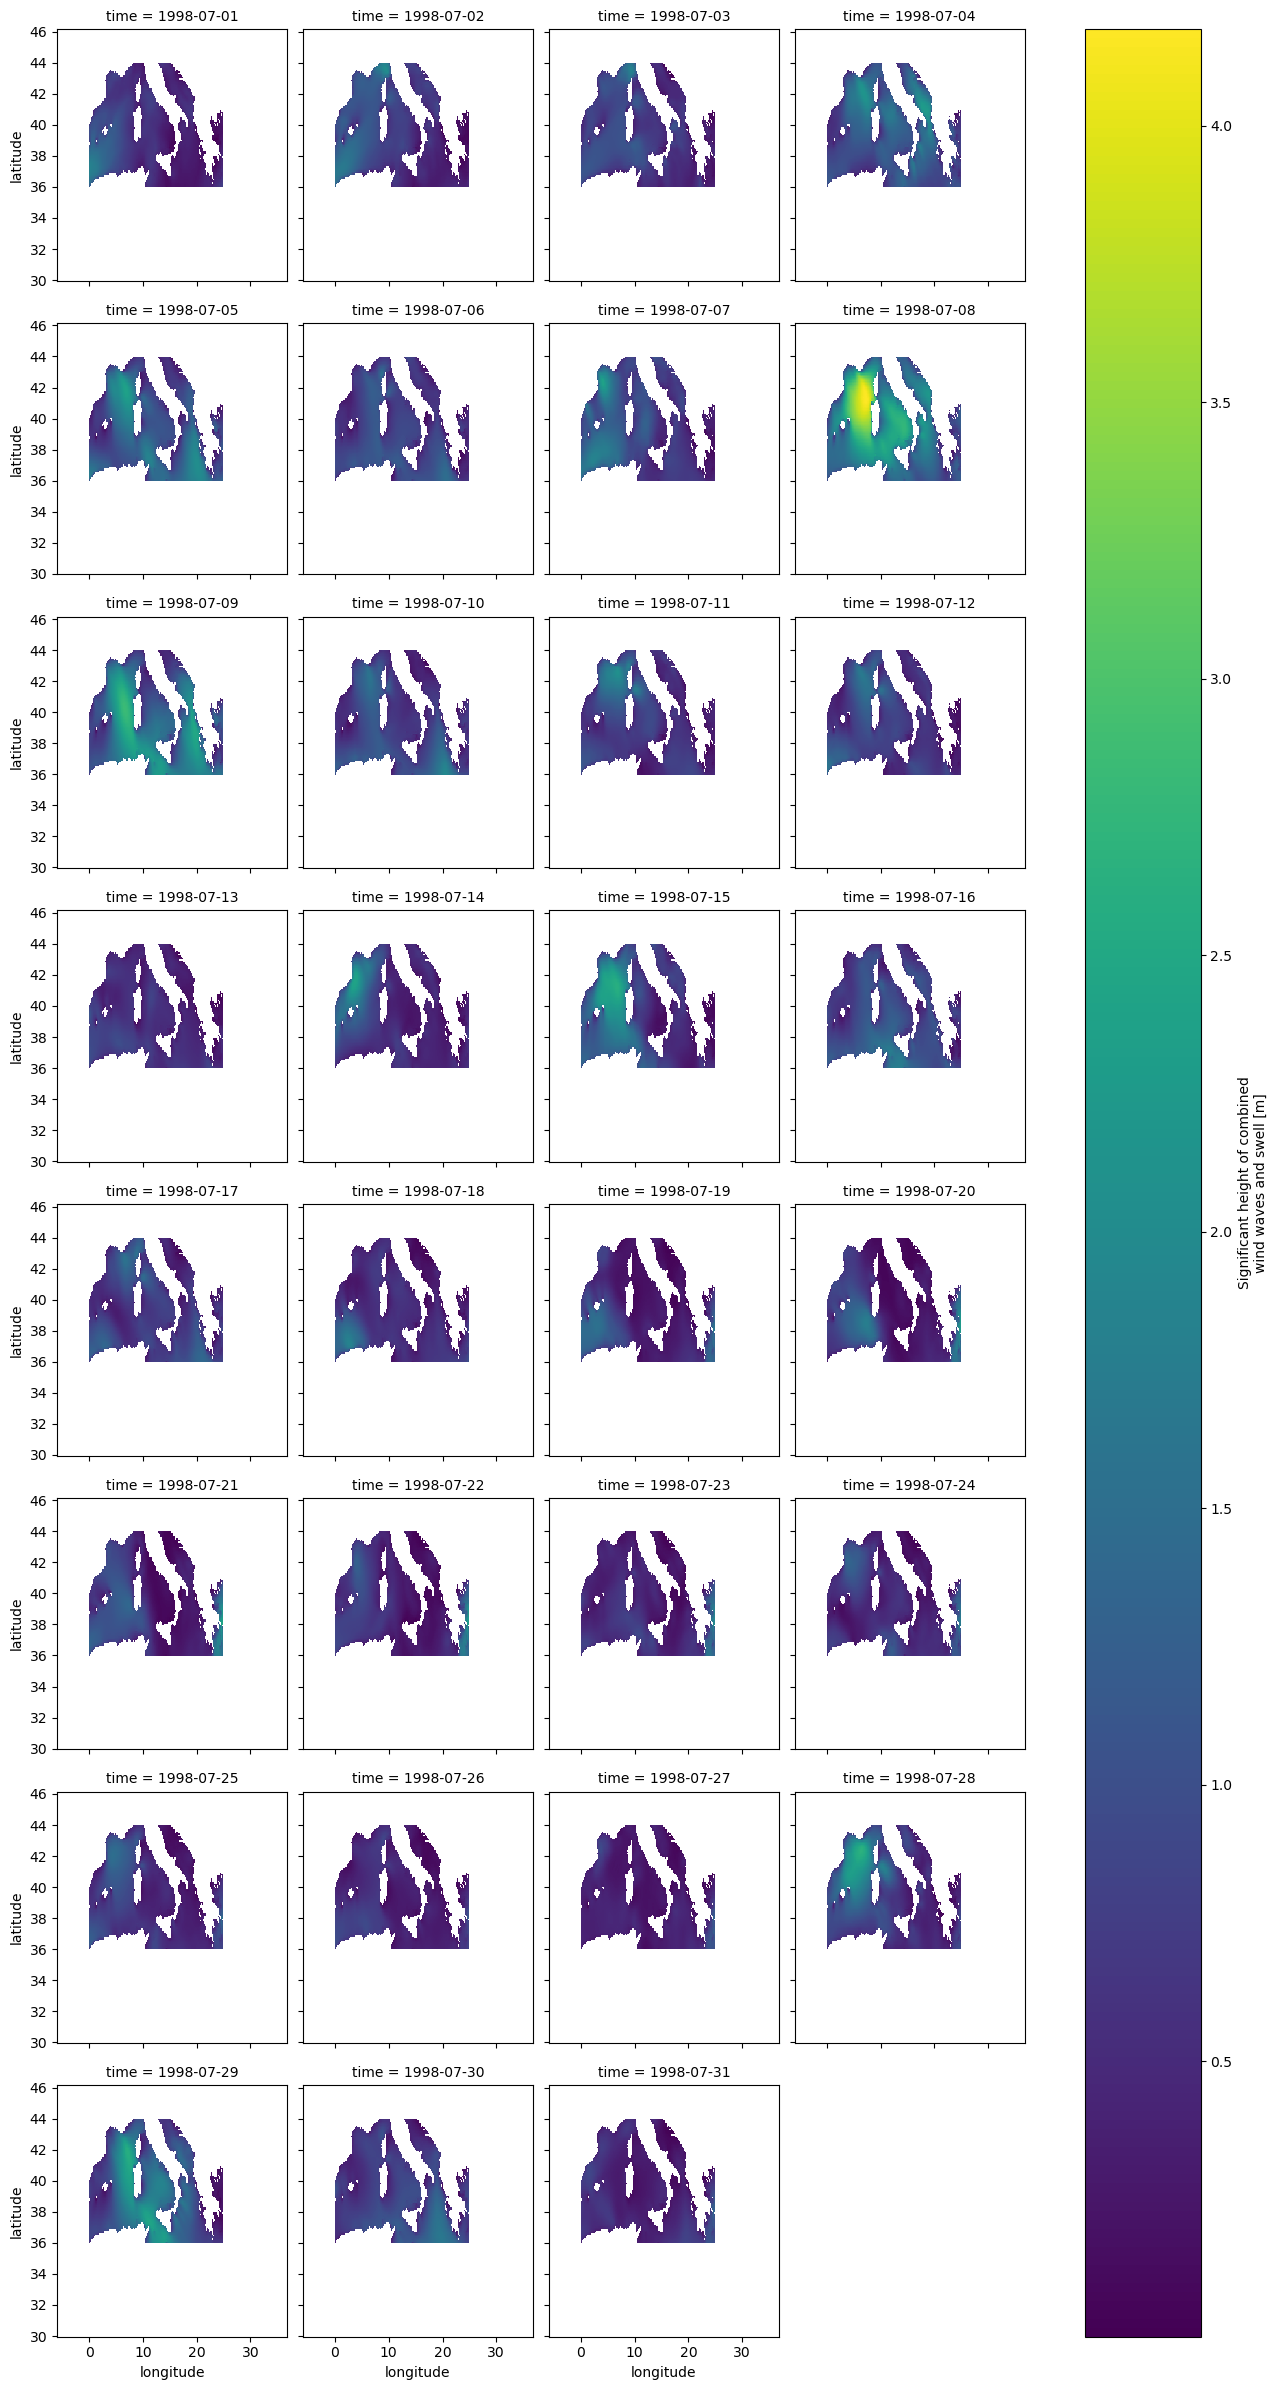

In [88]:
ds.where(
    (sample.latitude < 44) & (sample.latitude > 36) & 
    (sample.longitude > 0) & (sample.longitude < 25)
).resample({'time': 'D'}).mean().swh.plot(col='time', col_wrap=4)

### Using `where` with a custom fill value

`.where()` can take a second argument, which, if supplied, defines a fill value for the masked region. Below we fill masked regions with a constant `0`:

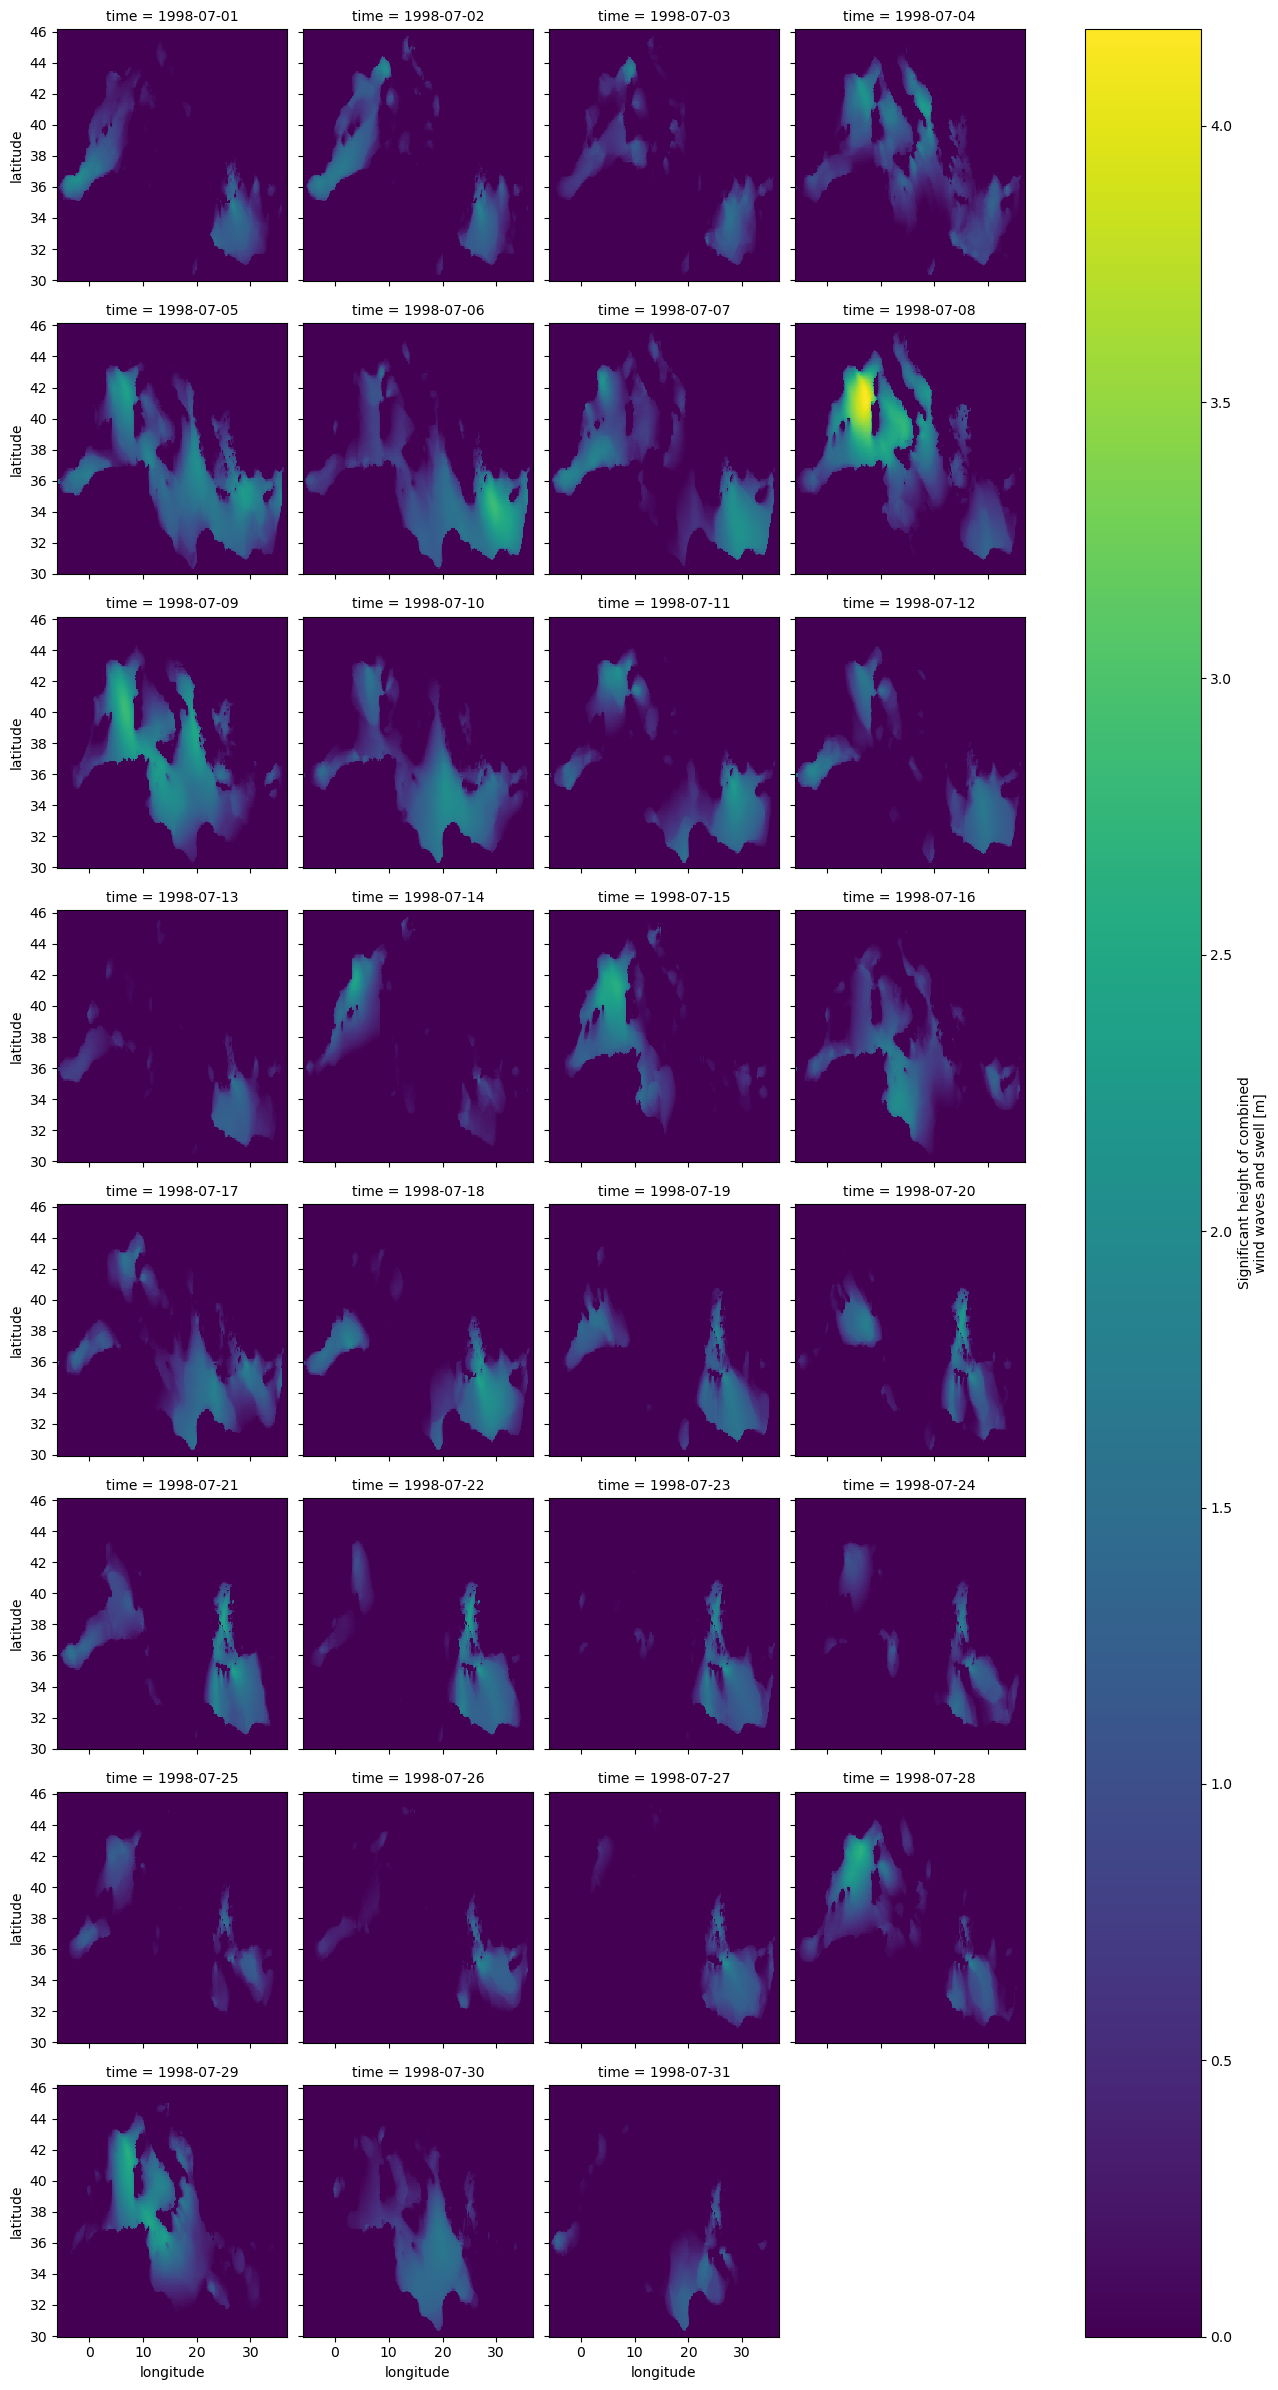

In [102]:
ds.swh.where(ds.swh>1, 0).resample({'time': 'D'}).mean().plot(col='time', col_wrap=4)

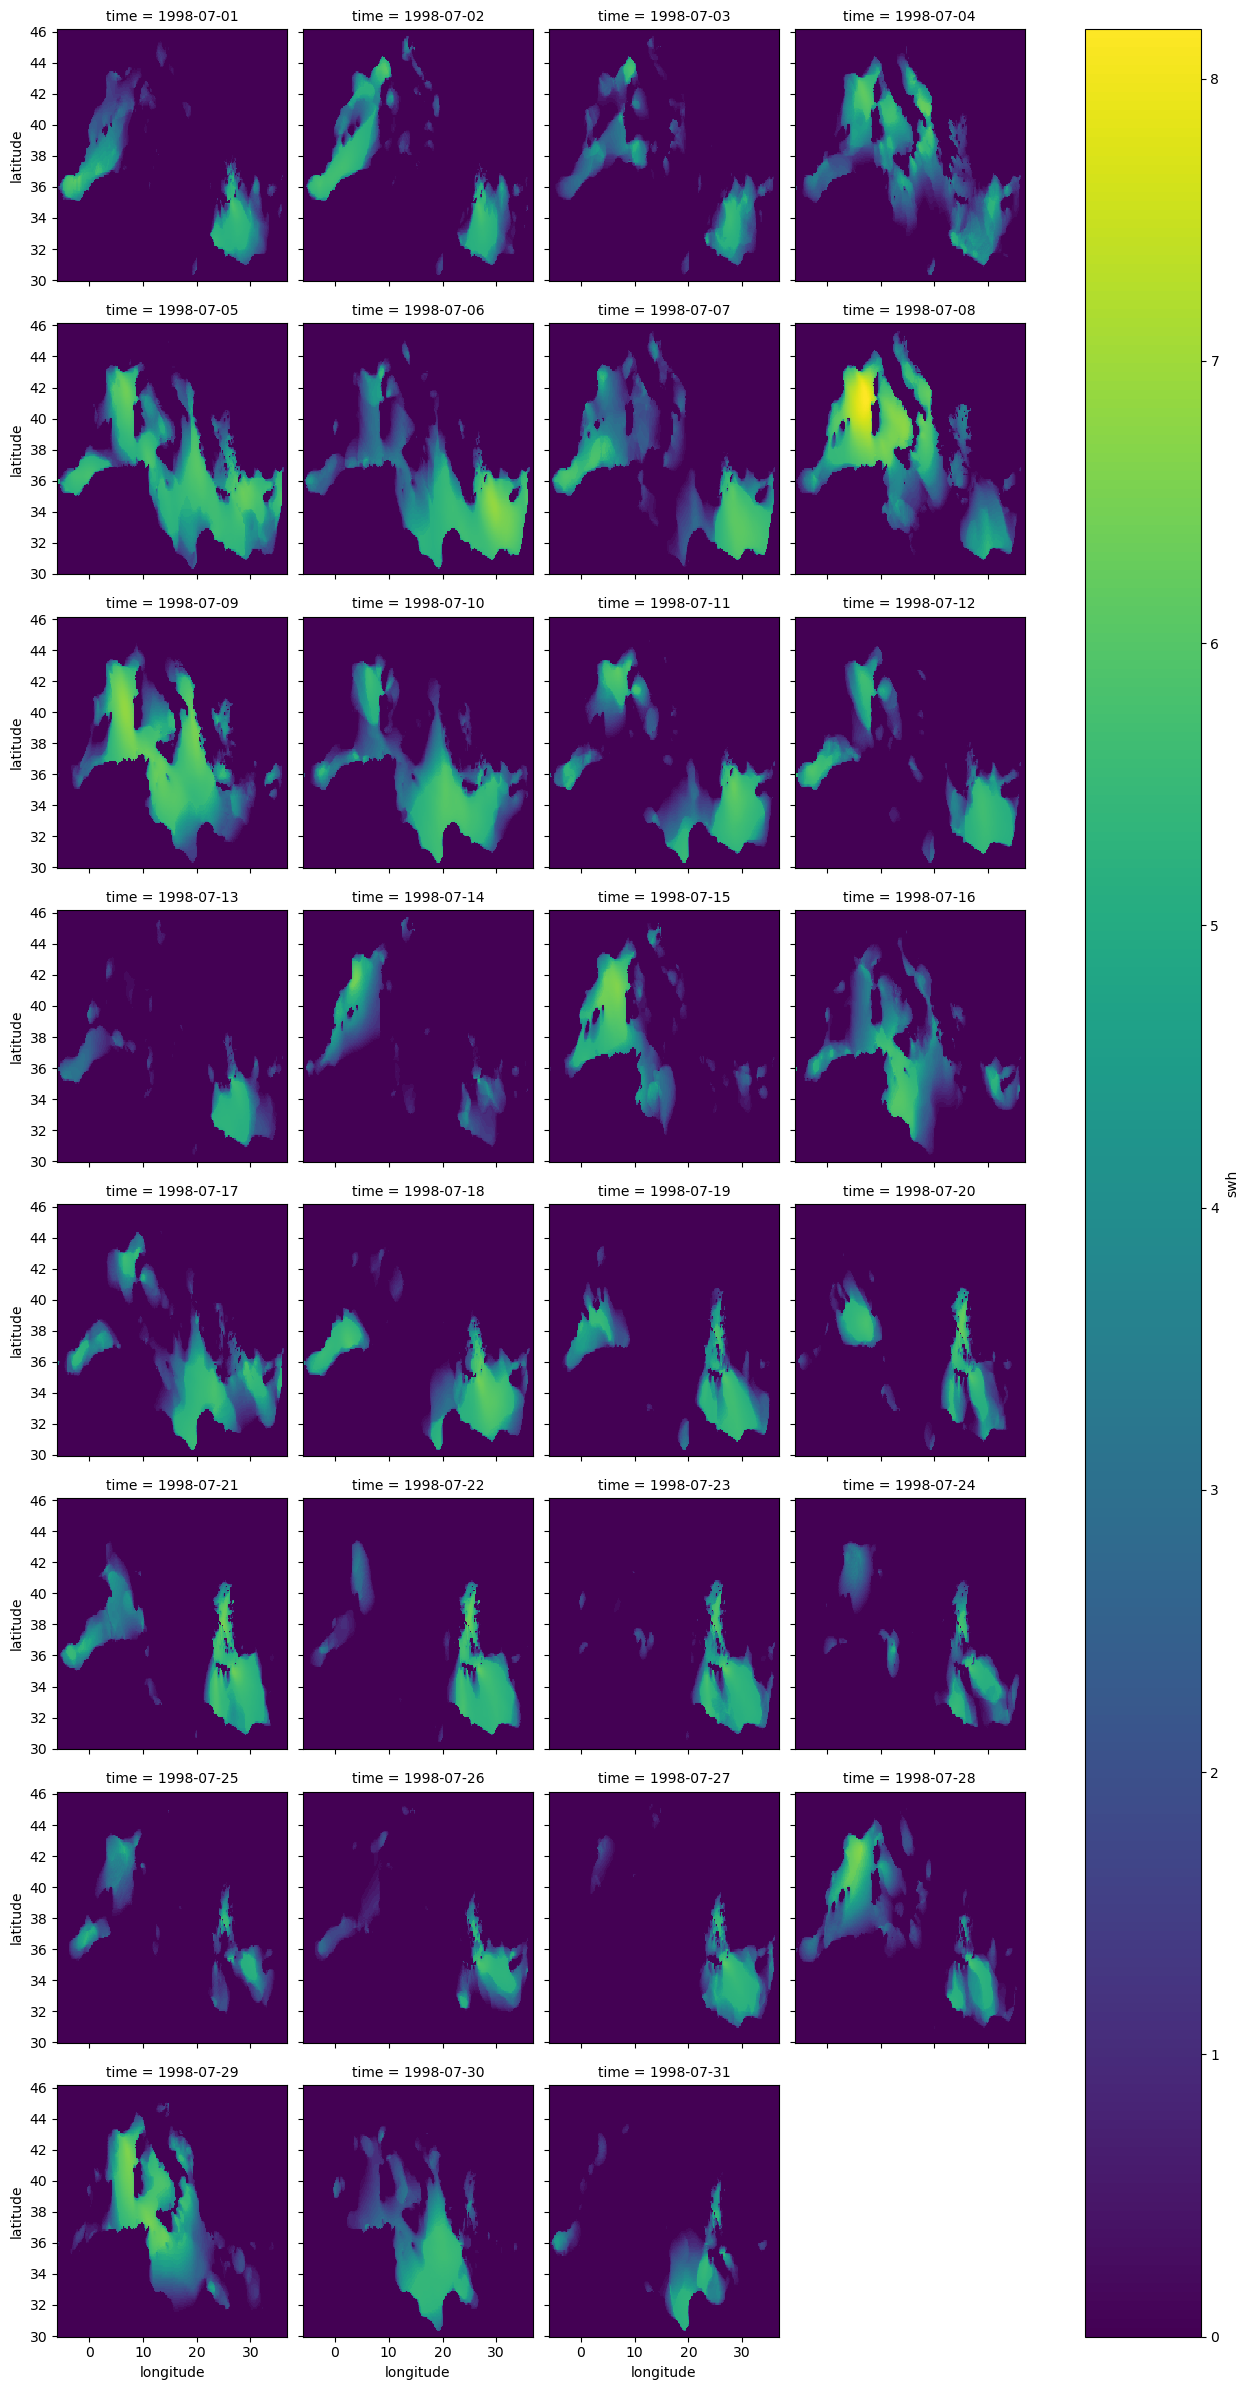

In [105]:
xr.where(ds.swh>1, ds.swh+4, 0).resample({'time': 'D'}).mean().plot(col='time', col_wrap=4)


---

## Resources and References

- `groupby`: [Useful for binning/grouping data and applying reductions and/or transformations on those groups](https://xarray.pydata.org/en/stable/user-guide/groupby.html)
- `resample`: [Groupby-like functionality specifialized for time dimensions. Can be used for temporal upsampling and downsampling](https://xarray.pydata.org/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
- `rolling`: [Useful for computing aggregations on moving windows of your dataset e.g. computing moving averages](https://xarray.pydata.org/en/stable/user-guide/computation.html#rolling-window-operations)
- `coarsen`: [Generic functionality for downsampling data](https://xarray.pydata.org/en/stable/user-guide/computation.html#coarsen-large-arrays)

- `weighted`: [Useful for weighting data before applying reductions](https://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions)

- [More xarray tutorials and videos](https://xarray.pydata.org/en/stable/tutorials-and-videos.html)
- [Xarray Documentation - Masking with `where()`](https://xarray.pydata.org/en/stable/user-guide/indexing.html#masking-with-where)